# Final Project:  Apartment Rent Determinants in Chicago

**Name**: Zhaoyin Liu

**Date**: May 27, 2019

**This submission is my work alone and complies with the 30531 integrity policy.
Add your initials to indicate your agreement: **ZL** **

## Environment Set Up
Before running the code, please make sure the following modules are installed:
* `CensusData`
* `geopandas`
* `Shapely`
* `statsmodels`
* `matplotlib`
* `beautifulsoup4`
* `requests`
* `pandas`
* `numpy`

## Part One: Getting Data

### 1. Getting Rent Data - Web Scraping
Apartment rent data of Chicago comes from [realtor.com](https://www.realtor.com/apartments/Chicago_IL). Since apartment information is changing, web scraping at different times will yield different results. 

**NOTE**: The following code only get data on the first 5 pages. **This project used data got on 2019-05-30 23:17:25.** It took 0:25:46.271802 to get data, containing 9988 results. The page rage of web scraping on May 30 was `'range(1,228)'`.**The file name of this data set is changed to `Chicago_Apartments_rent_0530.csv`. Please make sure it is downlaoded to your working directory.** 


In [1]:
import os
import time
import random
import datetime
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
params = {'page_range' :range(1,6),
          'sleep_time' :5,
          'path'       :os.path.expanduser('~/Desktop/Chicago_Apartments_rent.csv')}

class ScrapingRent():
    '''
    This class contains functions that use for web scraping.
    '''
    
    def __init__(self):
        self.data = pd.DataFrame()
    
    def get_data_on_one_page(self):
        '''
        This function loops through property cards on one webpage. Before iteration, empty lists are created
        to hold the value of each variables on this page. Lists are appended in the loop and this function will
        return a dataframe that contains latitude, longitude, price, name, productID, size and pet's term of 
        all properties of this webpage. 
        '''
        latitudes  = []
        longitudes = []
        prices     = []
        names      = []
        productIDs = []
        sizes      = []
        pets       = []

        for house in self.houses:
            # Get latitude
            latitude = house.find('meta', attrs={'itemprop':'latitude'})['content']
            latitudes.append(latitude)

            # Get longtitude
            longitude = house.find('meta', attrs={'itemprop':'longitude'})['content']
            longitudes.append(longitude)

            # Get price
            get_price = house.find('span',class_='data-price')
            if get_price is None:
                price = 'None'
            else:
                price = house.find('span',class_='data-price').text
            prices.append(price)

            # Get name
            name = house.find('meta', attrs={'itemprop':'name'})['content']
            names.append(name)

            # Get product ID
            productID = house.find('meta', attrs={'itemprop':'productID'})['content']
            productIDs.append(productID)
    
            # Get size
            get_size = house.find('li', attrs={'data-label':'property-meta-sqft'})
            if get_size is None:
                size = 'None'
            else:
                size = house.find('li', attrs={'data-label':'property-meta-sqft'}).span.text
            sizes.append(size)
    
            # Get pet permit
            get_pet = house.find('li', attrs={'data-label':'property-meta-pets'})
            if get_pet is None:
                pet = 'Not allow'
            else:
                    pet = house.find('li', attrs={'data-label':'property-meta-pets'}).span.text
            pets.append(pet)
                    
        return pd.DataFrame(
                {'productID': productIDs,
                 'latitude':latitudes,
                 'longitude':longitudes,
                 'price':prices,
                 'name':names,
                 'size':sizes,
                 'pet':pets
                })
   
    def get_all_data(self, page_range=params['page_range'], sleep_time=params['sleep_time']):
         
        '''
        This function will return a dataframe that contains all rent data. 
        This function loops through all pages containing rent information of aparments in Chicago. In the 
        loop, all property cards on one page are first save in "self.houses", then "get_data_on_one_page" 
        function is called and the resulting dataframe is appended to the dataframe("self.data") that 
        contains information of all pages. A 5 seconds sleep time is added before it iterate to another page.
        The dataframe that holds all the data will be saved in every iteration to avoid break down and loss of
        data.
        '''      
        for page in page_range: 

            url = 'https://www.realtor.com/apartments/Chicago_IL/pg-' + str(page)
            print('Scraping Page ' + str(page))
            headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.157 Safari/537.36'}
            response = requests.get(url, headers=headers)
            content = BeautifulSoup(response.text, 'html.parser')
            self.houses = content.find_all('li', class_="component_property-card js-component_property-card")
            
            one_page_data = self.get_data_on_one_page()
            
            self.data = self.data.append(one_page_data, ignore_index=True)
            
            print('Sleep time :' + str(sleep_time))
            time.sleep(sleep_time)
            
            self.data.to_csv(params['path'],index=False)
            
    
    def run(self):
        start = datetime.datetime.now()
        print('\n Web scraping start: ' + str(start))
        self.get_all_data()
        end = datetime.datetime.now()
        print('\n Web scraping end: ' + str(end))
        print('\n It takes ' + str(end-start) + ' to get data, containing ' + str(len(self.data)) + ' results.')
            

In [3]:
testing = ScrapingRent()
testing.run()


 Web scraping start: 2019-06-10 15:28:23.174926
Scraping Page 1
Sleep time :5
Scraping Page 2
Sleep time :5
Scraping Page 3
Sleep time :5
Scraping Page 4
Sleep time :5
Scraping Page 5
Sleep time :5

 Web scraping end: 2019-06-10 15:28:58.483644

 It takes 0:00:35.308718 to get data, containing 220 results.


### 2. Download Census Data 

**Note**: Before running, please install package `CensusData` which is designed to provide easy access to the U.S. Census Bureau’s API using code:

**`pip install CensusData`** or **`conda install CensusData`**.

In [4]:
path = os.path.expanduser('~/Desktop')

In [5]:
import censusdata

In [6]:
def get_CensusData():
    '''
    This funciton downloads ACS 2017 5-year estimates for all sensus tracts in Cook County, IL on population size, 
    median age, and median household income using U.S. Census Bureau’s API.
    '''
    print('Downloading census_data.csv...')
    df_census = censusdata.download('acs5', 2017, 
                                    censusdata.censusgeo([('state', '17'),('tract', '*')]), 
                                    ['B01001_001E', 'B01002_001E', 'B19013_001E','B23025_001E','B08303_002E',
                                     'B08303_003E','B08303_004E','B08303_005E','B08303_006E','B08303_007E'])
    censusdata.export.exportcsv(os.path.join( path, "census_data.csv"), df_census)
    print('census_data.csv is downloaded to' + str(path))


In [7]:
def download_from_CDP(filename, url):
    '''
    This function downlaod file from the Chicago Data Portal.
    '''
    print('Downloading '+ filename + ' ...')
    get_url = url
    response = requests.get(get_url)
    with open(os.path.join( path, filename), 'wb') as f:
        f.write(response.content)
    print(filename + ' is downloaded to ' + str(path))


In [8]:
get_CensusData()

download_from_CDP('tract_boundaries.zip',
                  'https://data.cityofchicago.org/api/geospatial/5jrd-6zik?method=export&format=Shapefile')

download_from_CDP('community_boundaries.zip',
                  'https://data.cityofchicago.org/api/geospatial/cauq-8yn6?method=export&format=Shapefile')

download_from_CDP('public_school.zip',
                  'https://data.cityofchicago.org/api/geospatial/3fhj-xtn5?method=export&format=Shapefile')

download_from_CDP('crimes_data.csv',
                  'https://data.cityofchicago.org/api/views/dfnk-7re6/rows.csv?accessType=DOWNLOAD')

download_from_CDP('grocery_data.csv',
                  'https://data.cityofchicago.org/api/views/ce29-twzt/rows.csv?accessType=DOWNLOAD')

census_data.csv is downloaded to/Users/liuzhaoyin/Desktop
tract_boundaries.zip is downloaded to /Users/liuzhaoyin/Desktop
community_boundaries.zip is downloaded to /Users/liuzhaoyin/Desktop
public_school.zip is downloaded to /Users/liuzhaoyin/Desktop
crimes_data.csv is downloaded to /Users/liuzhaoyin/Desktop
grocery_data.csv is downloaded to /Users/liuzhaoyin/Desktop


## Part II: Data Cleaning and Data Manipulation

 ### Loading Data

In [9]:
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [10]:
rent = pd.read_csv(os.path.join( path, "Chicago_Apartments_rent_0530.csv"))
crime = pd.read_csv(os.path.join( path, "crimes_data.csv"))
grocery = pd.read_csv(os.path.join( path, "grocery_data.csv"))
census = pd.read_csv(os.path.join( path, "census_data.csv"))

In [11]:
def unzip_shapefile(file):
    '''
    This function unzips the shapefile to the new folder'tract_boundaries', and change filenames to 'tract'+
    extension.
    '''
    # unzip
    import zipfile
    zip_shapefile = zipfile.ZipFile(os.path.join( path, file))
    zip_shapefile.extractall(os.path.join( path, file[:-4])) 
    
    # change filename
    for f in os.listdir(os.path.join( path, file[:-4])):
        for extension in ['.shp','.shx','.prj','.dbf']:
            if f.endswith(extension):
                os.rename(os.path.join( path, file[:-4],f),
                          os.path.join( path, file[:-4],file[:-4]+extension))

In [12]:
unzip_shapefile("community_boundaries.zip")
community_shape = geopandas.read_file(os.path.join(path,'community_boundaries','community_boundaries.shp'))

unzip_shapefile("public_school.zip")
school_location = geopandas.read_file(os.path.join(path,'public_school','public_school.shp'))

unzip_shapefile("tract_boundaries.zip")
tract_shape = geopandas.read_file(os.path.join(path,'tract_boundaries','tract_boundaries.shp'))
tract_shape['tractce10'] = tract_shape['tractce10'].astype(int)
tract_shape.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,POLYGON ((-87.62404799998049 41.73021699998396...
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((-87.6860799999848 41.82295600001154,..."
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((-87.62934700001182 41.8527970000265,..."
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,POLYGON ((-87.68813499997718 41.85569099999095...
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,POLYGON ((-87.63312200003458 41.87448800002695...


### 1. Cleaning Rent Data
#### (1) Removing properities with empty geospatial information, price or size.  

In [13]:
rent = rent.dropna()
rent = rent.drop(rent[rent['price'] == 'None'].index) 
rent = rent.drop(rent[rent['size'] == 'None'].index)
rent.isnull().values.any()

False

#### (2) Eliminating signs in `'price'` and `'size'`

In [14]:
replace = { '$':'', ',':'', '+':''}   
for k,v in replace.items():
    rent['price'] = rent['price'].str.replace(k,v)
    rent['size']  = rent['size'].str.replace(k,v)

#### (3) Transforming data type

In [15]:
rent['price'] = rent['price'].astype(int)
rent['size'] = rent['size'].astype(int)
rent['binary_pet'] = rent['pet'].map(lambda r : 1 if r=='OK'  else 0)
rent = rent.rename(columns={'name':'address'})
rent.head()

,productID,latitude,longitude,price,address,size,pet,binary_pet
0,8916537717,41.80368,-87.58492,1433,"5035 S East End Ave, Chicago, IL 60615",550,OK,1
1,7682331401,41.79627,-87.58151,1510,"5454 S Shore Dr, Chicago, IL 60615",542,Not allow,0
2,8695599317,41.79376,-87.58587,2075,"1616 E 56th St, Chicago, IL 60637",718,OK,1
3,7932179033,41.88546,-87.63463,2315,"215 W Lake St, Chicago, IL 60606",601,OK,1
4,7363678703,41.95820,-87.65118,1280,"833 W Buena Ave, Chicago, IL 60613",525,OK,1


#### (4) Creating new variable and remove outliers

In [16]:
rent['price_per_sqft'] = rent['price'] / rent['size']
rent = rent.drop(rent[rent['price_per_sqft'] == rent['price_per_sqft'].max()].index) 

### 2. Convert the `'rent'` , `'crime'` and `'grocery'` dataframe to GeoDataFrame  

In [17]:
def to_geodataframe(df,longtitude,latitude,crs_code):
    crs = {'init': crs_code}
    geometry = [Point(xy) for xy in zip(longtitude, latitude)]
    geodf = GeoDataFrame(df, crs=crs, geometry=geometry)
    return geodf

GeoRent = to_geodataframe(rent,rent.longitude,rent.latitude,'epsg:4326')

GeoCrime = to_geodataframe(crime,crime.LONGITUDE,crime.LATITUDE,'epsg:4326')

GeoGrocery = to_geodataframe(grocery,grocery.LONGITUDE,grocery.LATITUDE,'epsg:4326')
GeoGrocery.head()

,STORE NAME,LICENSE ID,ACCOUNT NUMBER,SQUARE FEET,BUFFER SIZE,ADDRESS,ZIP CODE,COMMUNITY AREA NAME,COMMUNITY AREA,WARD,...,LATITUDE,LONGITUDE,LOCATION,Community Areas,Zip Codes,Boundaries - ZIP Codes,Census Tracts,Wards,:@computed_region_awaf_s7ux,geometry
0,BOB'S LIQUORS & GROCERIES,957.0,86492.0,10001.0,A,5069 W MADISON ST,60644,AUSTIN,25,28,...,41.880296,-87.752494,"(41.8802960895, -87.7524941982)",26,22216,32,184,23,11,POINT (-87.7524941982 41.8802960895)
1,QUICK STOP FOOD MART,39791.0,3604.0,3000.0,B,2751 W PRATT BLVD,60645,WEST RIDGE,2,50,...,42.004750,-87.699423,"(42.0047500731, -87.6994227766)",20,22528,12,40,27,42,POINT (-87.6994227766 42.0047500731)
2,DOMINICK'S #147/1147,41674.0,5033.0,68000.0,A,1340 S CANAL ST,60607,NEAR WEST SIDE,28,2,...,41.864521,-87.639304,"(41.8645211937, -87.6393040996)",29,14917,44,97,48,48,POINT (-87.6393040996 41.8645211937)
3,CERMAK PRODUCE,1515206.0,279468.0,25000.0,A,5220 S PULASKI RD,60632,WEST ELSDON,62,23,...,41.797992,-87.723444,"(41.79799187, -87.7234437408)",60,22248,56,793,6,35,POINT (-87.72344374079999 41.79799187)
4,WHOLE FOODS MARKET,54059.0,86298.0,4501.0,B,3300 N ASHLAND AVE,60657,LAKE VIEW,6,44,...,41.941566,-87.668860,"(41.9415658578, -87.6688604029)",57,4449,22,742,18,38,POINT (-87.66886040290001 41.9415658578)


### 3. Merging Census Data to Tract Shapefile

#### (1) Cleaning Census Data

In [18]:

census['travel_time_to_work'] = census[['B08303_002E','B08303_003E','B08303_004E',
                                        'B08303_005E','B08303_006E','B08303_007E']].sum(axis=1)
census = census.rename(columns={'tract'      :'tractce10',
                                'B01001_001E':'population', 
                                'B01002_001E':'median_age',
                                'B19013_001E':'household_income',
                                'B23025_001E':'employment'})

census['population'] = census['population'].replace(0)
census['employment'] = census['employment'].replace(0)
census['travel_time_to_work'] = census['travel_time_to_work'] / census['employment']
census['travel_time_to_work'] = census['travel_time_to_work'].replace(0)
census['median_age'] = census['median_age'].replace(-666666666)
census['household_income'] = census['household_income'].replace(-666666666)
census['county'] = census['county'].astype(str)
census.describe()

,state,tractce10,population,median_age,household_income,employment,B08303_002E,B08303_003E,B08303_004E,B08303_005E,B08303_006E,B08303_007E,travel_time_to_work
count,3123.0,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,17.0,550658.070445,4128.793468,38.665226,63427.271854,3287.587576,50.827089,171.914825,225.854307,242.346142,236.713096,111.344541,0.311894
std,0.0,371654.169982,1982.958190,6.714930,31043.764425,1548.585898,62.172691,160.376123,177.699304,182.413539,171.613260,96.778460,0.111120
min,17.0,100.000000,8.000000,19.600000,2499.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005139
25%,17.0,71450.000000,2774.000000,33.900000,42411.000000,2220.000000,9.000000,64.000000,103.000000,116.000000,120.000000,44.000000,0.235008
50%,17.0,804102.000000,3856.000000,39.000000,57514.000000,3097.000000,31.000000,133.000000,190.000000,202.000000,204.000000,90.000000,0.308190
75%,17.0,851700.500000,5140.000000,43.300000,78072.500000,4065.000000,71.000000,231.000000,295.000000,320.500000,312.500000,151.000000,0.384401
max,17.0,990000.000000,28192.000000,68.400000,250001.000000,20758.000000,588.000000,2797.000000,2212.000000,1701.000000,2130.000000,1148.000000,0.800000


#### (2) Merging

In [19]:
geodf_with_census = tract_shape.merge(census, on='tractce10',how='left')
# Since some tracts belong to different counties, we just need to keep one of them.
geodf_with_census = geodf_with_census.drop(geodf_with_census[geodf_with_census['county']!='31'].index)
geodf_with_census.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,...,median_age,household_income,employment,B08303_002E,B08303_003E,B08303_004E,B08303_005E,B08303_006E,B08303_007E,travel_time_to_work
1,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,POLYGON ((-87.62404799998049 41.73021699998396...,...,44.6,39161,2559,0,8,36,72,105,22,0.094959
2,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((-87.6860799999848 41.82295600001154,...",...,34.3,48056,3115,0,47,130,232,166,35,0.195827
3,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((-87.62934700001182 41.8527970000265,...",...,45.1,26905,6020,149,119,396,633,329,13,0.272259
4,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,POLYGON ((-87.68813499997718 41.85569099999095...,...,30.5,36104,3897,38,104,291,146,344,190,0.285604
5,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,POLYGON ((-87.63312200003458 41.87448800002695...,...,33.0,84347,7954,66,101,675,1132,866,352,0.401308


### 4. Aggregating number of crimes, public schools and grocery stores in each tract and merging it with tract boundaries and census data

In [20]:
def aggregation(point_df, origin_df, key, new_valname):
    '''
    This function aggregates number of datapoint in each tract and merge it with 'geodf_with_census'dataframe.
    '''
    np.seterr(divide='ignore',invalid='ignore')
    # Join dataframe spatially, return dataframe that shows which tract a datapoint is belong to.  
    join = geopandas.sjoin(point_df, origin_df, op='within')
    # Aggregate number of points in each tract
    agg = join[key].value_counts().rename_axis(key).reset_index(name=new_valname)
    # Join aggregate number of points with the origin dataframe
    joindf = origin_df.merge(agg, on=key, how='left')
    
    return joindf

In [21]:
tract_data = aggregation(GeoCrime, geodf_with_census, 'tractce10', 'cri_count')
tract_data = aggregation(GeoGrocery, tract_data , 'tractce10', 'grocery_count')
tract_data = aggregation(school_location, tract_data , 'tractce10', 'school_count')
tract_data['school_count'] = tract_data['school_count'].fillna(0)
tract_data['grocery_count'] = tract_data['grocery_count'].fillna(0)
tract_data.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,...,B08303_002E,B08303_003E,B08303_004E,B08303_005E,B08303_006E,B08303_007E,travel_time_to_work,cri_count,grocery_count,school_count
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,POLYGON ((-87.62404799998049 41.73021699998396...,...,0,8,36,72,105,22,0.094959,1336,3.0,3.0
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((-87.6860799999848 41.82295600001154,...",...,0,47,130,232,166,35,0.195827,187,1.0,1.0
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((-87.62934700001182 41.8527970000265,...",...,149,119,396,633,329,13,0.272259,453,3.0,1.0
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,POLYGON ((-87.68813499997718 41.85569099999095...,...,38,104,291,146,344,190,0.285604,267,0.0,1.0
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,POLYGON ((-87.63312200003458 41.87448800002695...,...,66,101,675,1132,866,352,0.401308,752,0.0,1.0


### 5. Merging all data together by apartment. 

In [22]:
# Merge
all_data_by_apt = geopandas.sjoin(GeoRent, tract_data, op='within')

# Save data
all_data_by_apt.to_csv(os.path.join( path, "all_data_by_apt.csv"),index=False)
all_data_by_apt.head()

,productID,latitude,longitude,price,address,size,pet,binary_pet,price_per_sqft,geometry,...,B08303_002E,B08303_003E,B08303_004E,B08303_005E,B08303_006E,B08303_007E,travel_time_to_work,cri_count,grocery_count,school_count
0,8916537717,41.803680,-87.584920,1433,"5035 S East End Ave, Chicago, IL 60615",550,OK,1,2.605455,POINT (-87.58492 41.80368),...,0,39,34,208,678,144,0.219241,297,1.0,1.0
243,7413947587,41.804120,-87.584480,1387,"1649 E 50th St, Chicago, IL 60615",428,OK,1,3.240654,POINT (-87.58448 41.80412),...,0,39,34,208,678,144,0.219241,297,1.0,1.0
4044,8011702047,41.806859,-87.586260,1000,"4800 S Chicago Beach Dr Unit 1809 N, Chicago, ...",475,Not allow,0,2.105263,POINT (-87.58626 41.806859),...,0,39,34,208,678,144,0.219241,297,1.0,1.0
7009,7475805045,41.804049,-87.584431,2659,"1649 E 50th 022 A Unit 022 A, Chicago, IL 60615",972,OK,1,2.735597,POINT (-87.58443100000001 41.804049),...,0,39,34,208,678,144,0.219241,297,1.0,1.0
7068,7475842311,41.804049,-87.584431,1553,"1649 E 50th 013 E Unit 013 E, Chicago, IL 60615",752,OK,1,2.065160,POINT (-87.58443100000001 41.804049),...,0,39,34,208,678,144,0.219241,297,1.0,1.0


### 6. Aggregating mean rent in each tract and merge back to the tract boundaries dataframe

In [23]:
avg_price_per_sqft= all_data_by_apt.groupby('tractce10').mean()['price_per_sqft'].rename_axis('tractce10').reset_index(name='avg_price_per_sqft')
avg_price         = all_data_by_apt.groupby('tractce10').mean()['price'].rename_axis('tractce10').reset_index(name='avg_price')

all_data_by_tract = tract_data.merge(avg_price_per_sqft, on='tractce10', how='left')
all_data_by_tract = all_data_by_tract.merge(avg_price, on='tractce10', how='left')

all_data_by_tract.to_csv(os.path.join( path, "all_data_by_tract.csv"),index=False)

all_data_by_tract.head()


,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,...,B08303_004E,B08303_005E,B08303_006E,B08303_007E,travel_time_to_work,cri_count,grocery_count,school_count,avg_price_per_sqft,avg_price
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,POLYGON ((-87.62404799998049 41.73021699998396...,...,36,72,105,22,0.094959,1336,3.0,3.0,1.027094,1250.000000
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((-87.6860799999848 41.82295600001154,...",...,130,232,166,35,0.195827,187,1.0,1.0,1.299333,1325.000000
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((-87.62934700001182 41.8527970000265,...",...,396,633,329,13,0.272259,453,3.0,1.0,1.500433,2198.333333
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,POLYGON ((-87.68813499997718 41.85569099999095...,...,291,146,344,190,0.285604,267,0.0,1.0,1.433333,1743.750000
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,POLYGON ((-87.63312200003458 41.87448800002695...,...,675,1132,866,352,0.401308,752,0.0,1.0,2.854106,2483.004587


## Part III: Descriptive Analysis

In [24]:
import matplotlib.pyplot as plt
from pandas.plotting import table

### 1. Summarize data

In [25]:
describe_by_apt = all_data_by_apt[['price','size','price_per_sqft','binary_pet']].describe()
describe_by_apt.to_csv(os.path.join( path, "Summarize(Apt).csv"),index=False)
describe_by_apt

,price,size,price_per_sqft,binary_pet
count,6500.000000,6500.000000,6500.000000,6500.000000
mean,2323.554462,988.943077,2.551134,0.580000
std,1596.996341,664.399822,1.062057,0.493596
min,100.000000,81.000000,0.011299,0.000000
25%,1519.750000,650.000000,1.750000,0.000000
50%,2015.000000,842.000000,2.572940,1.000000
75%,2650.000000,1181.000000,3.259882,1.000000
max,37500.000000,24500.000000,22.300469,1.000000


In [26]:
describe_by_tract = all_data_by_tract.loc[:, 'population':'avg_price'].describe()
describe_by_tract.to_csv(os.path.join( path, "Summarize(Tract).csv"),index=False)
describe_by_tract

,population,median_age,household_income,employment,B08303_002E,B08303_003E,B08303_004E,B08303_005E,B08303_006E,B08303_007E,travel_time_to_work,cri_count,grocery_count,school_count,avg_price_per_sqft,avg_price
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,604.000000,604.000000
mean,3450.315855,34.992010,54032.558052,2783.511860,15.349563,59.248439,109.621723,144.853933,188.784020,87.401998,0.209809,309.416979,0.631710,0.848939,1.636356,1689.003659
std,1856.714214,6.197742,29690.977171,1551.450458,25.531063,72.843596,120.509120,149.122047,166.269095,87.260519,0.088693,298.742361,0.886252,0.986611,0.651566,805.053754
min,341.000000,20.100000,10471.000000,257.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018872,3.000000,0.000000,0.000000,0.024125,100.000000
25%,2019.000000,30.700000,32500.000000,1624.000000,0.000000,17.000000,39.000000,56.000000,79.000000,26.000000,0.150042,140.000000,0.000000,0.000000,1.165432,1159.687500
50%,3083.000000,34.000000,44990.000000,2513.000000,6.000000,40.000000,80.000000,106.000000,146.000000,65.000000,0.201304,230.000000,0.000000,1.000000,1.478416,1500.000000
75%,4512.000000,38.700000,68899.000000,3613.000000,21.000000,79.000000,140.000000,186.000000,259.000000,122.000000,0.256455,386.000000,1.000000,1.000000,1.981145,2073.906250
max,19015.000000,66.300000,160833.000000,16399.000000,255.000000,934.000000,1183.000000,1373.000000,2130.000000,1148.000000,0.577224,4637.000000,6.000000,6.000000,4.409473,8669.000000


In [27]:
def plot_his_box(df,v,var_name,title):
    
    fig, axs = plt.subplots(1,2, figsize=(20,6))
    fig.subplots_adjust(top=0.8)

    ax=axs[0]
    n, bins, patches = ax.hist(df[v], bins=75, edgecolor='#8CD790',
                               facecolor='#8CD790', alpha=0.75)
    ax.set_title('Histogram of ' + var_name)
    
    ax=axs[1]
    dot_pattern = dict(markerfacecolor='#8FBC94', marker='D',markeredgecolor='#8CD790')
    ax.boxplot(df[v],flierprops=dot_pattern)
    ax.set_title('Boxplot of ' + var_name)
    
    fig.suptitle(title, fontsize=20,fontweight='bold',va='top')
    
    plt.savefig(os.path.join(path, title+'.png'))
    print('Figure saved to' + str(path))

    plt.show()


Figure saved to/Users/liuzhaoyin/Desktop


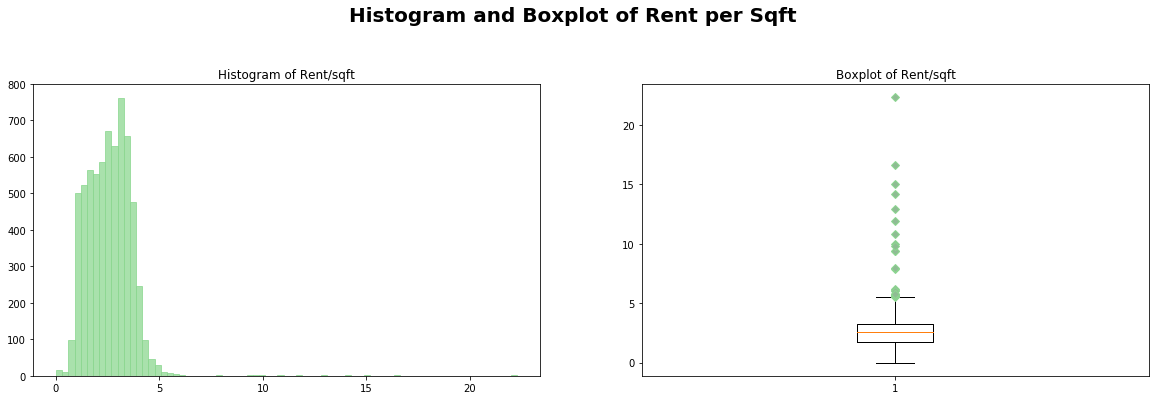

In [28]:
plot_his_box(all_data_by_apt,'price_per_sqft', 'Rent/sqft', 'Histogram and Boxplot of Rent per Sqft')

### 2. Graduate Symbol Map 

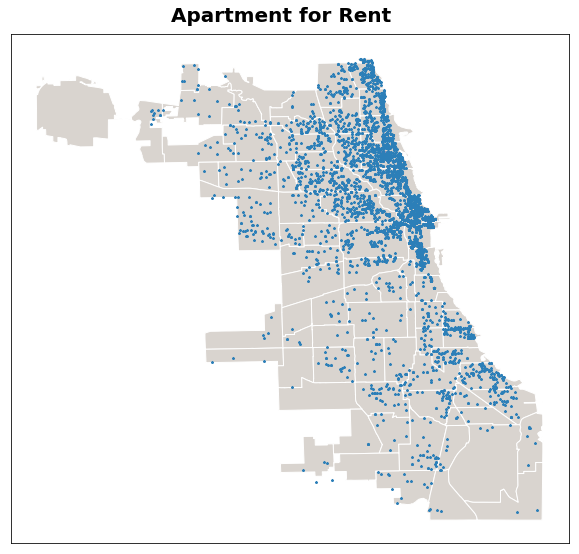

In [29]:
def dot_map(gdf_boundary, gdf_dot):
    
    # Conver coordinate reference system
    gdf_dot = gdf_dot.to_crs(gdf_boundary.crs)
    
    # plotting
    fig, ax = plt.subplots(figsize=(10,10))
    fig.subplots_adjust(top=1.05)
    ax.set_aspect('equal')
    gdf_boundary.plot(ax=ax, color='#D9D4CF', edgecolor='white')
    gdf_dot.plot(ax=ax, marker='*', color='#2c7fb8', markersize=5)
    
    # change layout   
    fig.suptitle('Apartment for Rent', fontsize=20,fontweight='bold')
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
        tic.label1On = tic.label2On = False
    
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
        tic.label1On = tic.label2On = False
        
    plt.show()
    
    
dot_map(community_shape, all_data_by_apt)

Figure saved to/Users/liuzhaoyin/Desktop


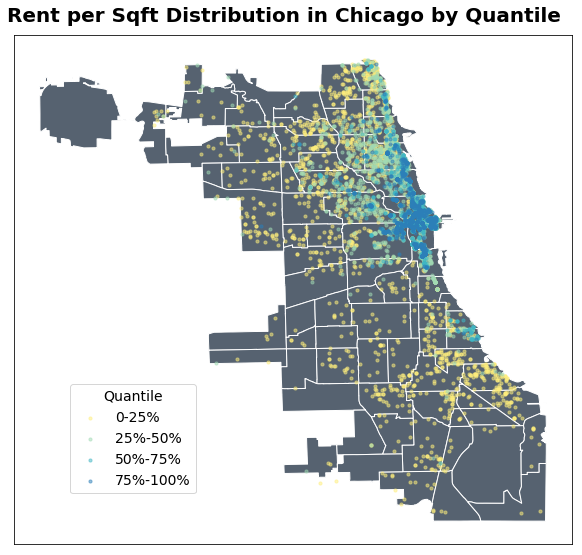

In [30]:
def get_quantile(df,var):
    '''
    This function returns a series that indicates what quantile a observation belongs to. 
    '''
    df['0-25%']    = df[var].map(lambda r :'0-25%'   if r<df[var].quantile(0.25) else '')
    df['25%-50%']  = df[var].map(lambda r :'25%-50%' if df[var].quantile(0.25)<=r<df[var].quantile(0.5) else '')
    df['50%-75%']  = df[var].map(lambda r :'50%-75%' if df[var].quantile(0.5)<=r<df[var].quantile(0.75) else '')
    df['75%-100%'] = df[var].map(lambda r :'75%-100%'if r>=df[var].quantile(0.75) else '')
    cat = df['75%-100%'].str.cat(df['50%-75%'].str.cat(df['0-25%'].str.cat(df['25%-50%'],sep=''),sep=''),sep='')
    return cat


def graduate_symbol_dotmap(variable,title):
    '''
    This function returns a graduate symbol map. 
    '''
    point_pattern = {'0-25%'   : '#feee7d', '25%-50%' : '#a1dab4', 
                     '50%-75%' : '#41b6c4', '75%-100%': '#2c7fb8'} 
    
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.subplots_adjust(top=1.05)
    
    # base map
    community_shape.plot(ax=ax, color='#566270', edgecolor='white')
    
    # graduate symbol map
    for quantile, data in all_data_by_apt.groupby(variable):
        color = point_pattern[quantile]
        label = quantile 
        data.plot(color=color,
                  ax=ax,
                  label=label,
                  markersize=10,
                  alpha=0.5)
        
    # changing lay out    
    ax.legend(fontsize=14,frameon=True,loc=(.1, .1),title="Quantile",title_fontsize=14)
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
        tic.label1On = tic.label2On = False
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
        tic.label1On = tic.label2On = False    
    fig.suptitle(title, fontsize=20,fontweight='bold')
    
    plt.savefig(os.path.join(path, title+'.png'))
    print('Figure saved to' + str(path))
    
    plt.show()

    
all_data_by_apt['quantile'] = get_quantile(all_data_by_apt,'price_per_sqft')
graduate_symbol_dotmap('quantile','Rent per Sqft Distribution in Chicago by Quantile')   



Reference for not showing the axis ticks:
https://stackoverflow.com/questions/20416609/remove-the-x-axis-ticks-while-keeping-the-grids-matplotlib

### 3. Choropleth Map

In [31]:
def choropleth_map(df,v1,t1,v2,t2,v3,t3,v4,t4,v5,t5,v6,t6): 
    '''
    This funcition returns choropleth Maps of the selected variables
    '''
    
    import warnings
    warnings.filterwarnings("ignore")
    print('Some variables have not enough unique values in array to form 5 classes, number of class set to 3')
    
    fig, axs = plt.subplots(3,2, figsize=(15,25), subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(top=1.2)
    
      
    ax = axs[0,0]
    clean1 = df[df[v1].notnull()]
    community_shape.plot(ax=ax, color='#566270', edgecolor='#566270')
    clean1.plot(ax=ax, column=v1, cmap='viridis_r', scheme='quantiles', edgecolor='white',linewidth = 0.5,legend=True)
    ax.set_title(t1)
        
    ax = axs[0,1]
    clean2 = df[df[v2].notnull()]
    community_shape.plot(ax=ax, color='#566270', edgecolor='#566270')
    clean2.plot(ax=ax, column=v2, cmap='GnBu', scheme='quantiles', edgecolor='white',linewidth = 0.5,legend=True)
    ax.set_title(t2)
     
    ax = axs[1,0]
    clean3 = df[df[v3].notnull()]
    community_shape.plot(ax=ax, color='#566270', edgecolor='#566270')
    clean3.plot(ax=ax, column= v3, cmap='GnBu', scheme='quantiles', edgecolor='white',linewidth = 0.5,legend=True)
    ax.set_title(t3)
    
    ax = axs[1,1]
    clean4 = df[df[v4].notnull()]
    community_shape.plot(ax=ax, color='#566270', edgecolor='#566270')
    clean4.plot(ax=ax, column=v4,cmap='GnBu', scheme='quantiles', edgecolor='white',linewidth = 0.5,legend=True)
    ax.set_title(t4)
    
    ax = axs[2,0]
    clean5 = df[df[v5].notnull()]
    clean5 = clean5.drop(clean5[clean5[v5] < 0].index)
    community_shape.plot(ax=ax, color='#566270', edgecolor='#566270')
    clean5.plot(ax=ax, column=v5, cmap='GnBu', scheme='quantiles', edgecolor='white',linewidth = 0.5,legend=True)
    ax.set_title(t5)
    
    ax = axs[2,1]
    clean6 = df[df[v6].notnull()]
    clean6 = clean6.drop(clean6[clean6[v6] < 0].index)
    community_shape.plot(ax=ax, color='#566270', edgecolor='#566270')
    clean6.plot(ax=ax, column=v6, cmap='GnBu', scheme='quantiles', edgecolor='white',linewidth = 0.5,legend=True)
    ax.set_title(t6)   
       
    fig.suptitle('Average Rent in Chicago with Sensus Data (Tract Level)', 
                 fontsize=24,fontweight='bold')
    
    fig.tight_layout()
    
    plt.savefig(os.path.join(path, 'Choropleth_Maps.png'))
    print('Figure saved to' + str(path))
    
    plt.show()

Some variables have not enough unique values in array to form 5 classes, number of class set to 3
Figure saved to/Users/liuzhaoyin/Desktop


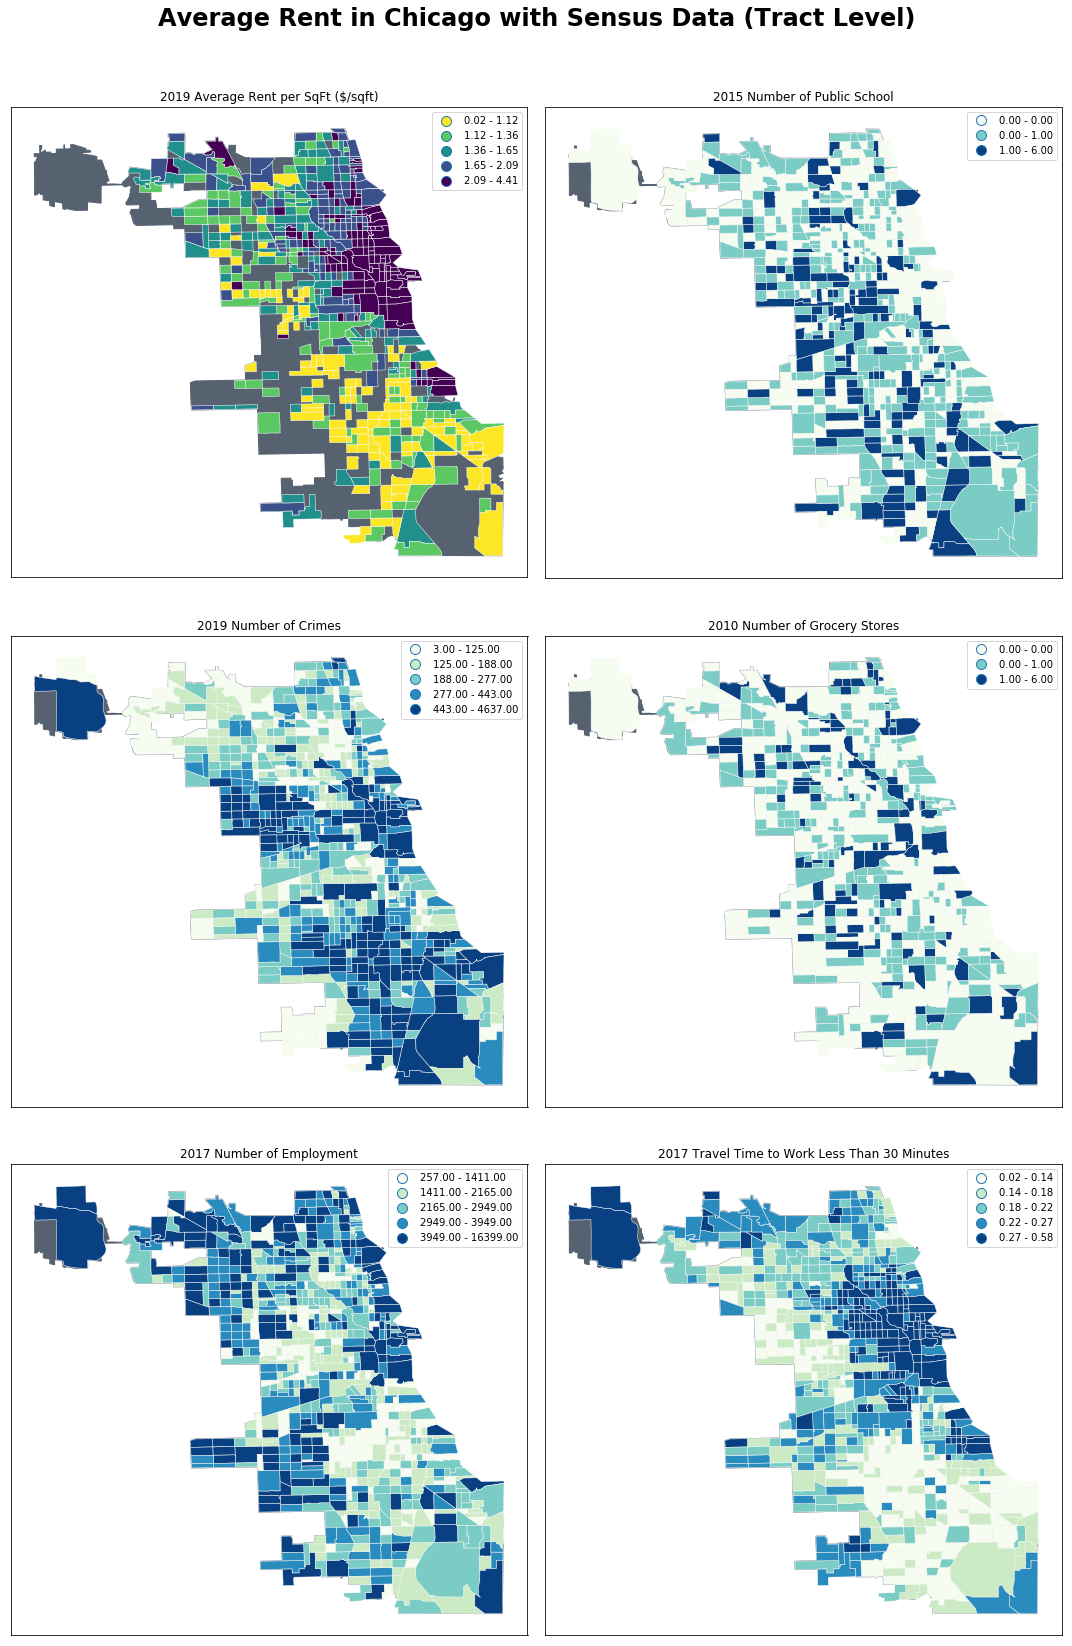

In [32]:
choropleth_map(all_data_by_tract, 
               'avg_price_per_sqft' , '2019 Average Rent per SqFt ($/sqft)',
               'school_count'       , '2015 Number of Public School',
               'cri_count'          , '2019 Number of Crimes',
               'grocery_count'      , '2010 Number of Grocery Stores',
               'employment'         , '2017 Number of Employment',
               'travel_time_to_work', '2017 Travel Time to Work Less Than 30 Minutes')

## Part IV: Regression

In [33]:
import statsmodels.api as sm

In [34]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

X = all_data_by_apt[['binary_pet','employment','grocery_count','cri_count','travel_time_to_work','school_count']]
X = sm.add_constant(X)
Y = all_data_by_apt['price_per_sqft']

In [35]:
reg1 = sm.OLS(Y,X,missing='drop' )                                                                          
results1 = reg1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_sqft   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     752.5
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:30:44   Log-Likelihood:                -7898.3
No. Observations:                6500   AIC:                         1.581e+04
Df Residuals:                    6493   BIC:                         1.586e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.7790    

In [36]:
results1.params 

const                  0.779001
binary_pet             0.139347
employment             0.000035
grocery_count         -0.049256
cri_count              0.000085
travel_time_to_work    4.599325
school_count          -0.093285
dtype: float64

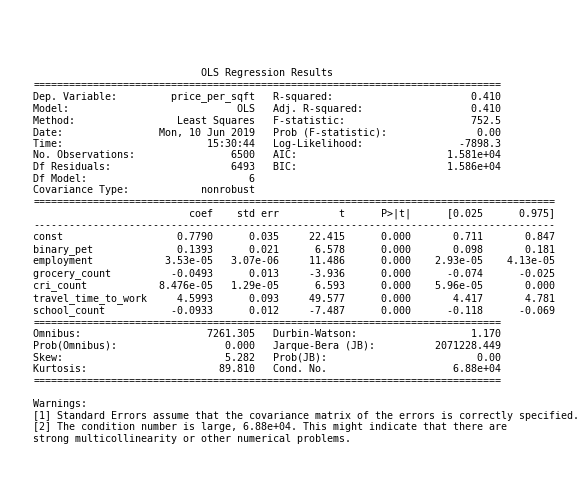

In [37]:
plt.rc('figure', figsize=(7, 7))
plt.text(0.01, 0.05, str(results1.summary()), {'fontsize': 12}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(path, 'OLS output.png'))

Reference: https://stackoverflow.com/questions/46664082/save-statsmodels-results-in-python-as-image-file